In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import pickle
import datetime

plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

# error analysis

## InceptionTime on predicting GA

**Analyses**
- [ ] (1) clustering and purity per metadata feature
- [x] (2) manual cohort creation, chi-sq or mwu per feature

In [2]:
def load_md_GAerror(sfp='/home/ngr4/project', verbose=False):
    '''Get the metadata, error on primary task, and eval_metric on md columns.
    
    TODO (#enhancement): pull from results file and normalize eval_metric to be able to acc/mae
    
    Arugments:
      sfp: path to wearables and featnets project scripts
      
    Returns:
      md
    '''
    # get md and error for node color
    import sys
    sys.path.append(sfp)
    import wearables.scripts.train as weartrain

    trainer = weartrain.InceptionTimeRegressor_trainer(trial=0, 
                                                       patience=None, n_epochs=2000,
                                                       batch_size=32)
    res = trainer.eval_test(modelpkl='/home/ngr4/project/wearables/model_zoo/61-InceptionTime_GA4.pkl', eval_trainset=True)
    md = res['md']

    return md

def allmd_results(norm=False, sfp='/home/ngr4/project'):
    md_res = pd.read_csv('/home/ngr4/project/wearables/results/InceptionTimev0.2_allmd.csv', index_col=0)

    if norm:
        # get md and error for node color
        import sys
        sys.path.append(sfp)
        import wearables.scripts.train as weartrain

        trainer = weartrain.InceptionTimeRegressor_trainer(trial=0, 
                                                           patience=None, n_epochs=2000,
                                                           batch_size=32)
        res = trainer.eval_test(modelpkl='/home/ngr4/project/wearables/model_zoo/61-InceptionTime_GA4.pkl', eval_trainset=True)
        md = res['md']
        
        # normalize by mean value
        md_res['ave_p1norm'] = md_res['target'].map(md.astype(np.float32).abs().mean().to_dict())
        md_res.loc[md_res['tasktype']=='regression', 'eval_test'] = (1 - md_res.loc[md_res['tasktype']=='regression', 'eval_test'] / md_res.loc[md_res['tasktype']=='regression', 'ave_p1norm'] )

    # output eval_test
    md_res_error = md_res.groupby(['target']).mean()['eval_test'].to_dict()
    return md_res_error

In [3]:
md = load_md_GAerror()

/gpfs/ysm/project/dijk/ngr4/conda_envs/wearables/lib/python3.8/site-packages/torch/nn/modules/conv.py:294: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/Convolution.cpp:660.)
  return F.conv1d(input, weight, bias, self.stride,
/gpfs/ysm/project/dijk/ngr4/conda_envs/wearables/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


train set eval:
  bst epoch: None
  <loss_train>=63.5099
  eval_train  =6.7440


### Stratification

#### Manual gating
- lowpredhigh
- lt10wk error
- highpredlow

In [6]:
savefigs = False

NameError: name 'savefigs' is not defined

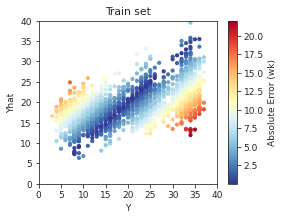

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

im = ax.scatter(md['GA'], md['yhatGA'], c=md['Absolute Error'], s=10, cmap='RdYlBu_r', rasterized=True)
cbar = fig.colorbar(im)
cbar.set_label('Absolute Error (wk)')
ax.set_title('Train set')
ax.set_xlabel('Y')
ax.set_ylabel('Yhat')
ax.set_xlim([0, 40])
ax.set_ylim([0, 40])
ax.set_xticks(ax.get_yticks())

if savefigs:
    fig.savefig('/home/ngr4/project/wearables/results/ITRerror_analysis_error_train.png',
                bbox_inches='tight', dpi=600)
    savefigs = False


In [5]:
# define clusters
median_GA = md['GA'].median()

lowpredhigh = md.loc[(md['Absolute Error'] > 10.) & 
                     (md['GA'] <= median_GA) & 
                     (md['yhatGA'] > md['GA']), :].index
highpredlow = md.loc[(md['Absolute Error'] > 10.) & 
                     (md['GA'] > median_GA) & 
                     (md['yhatGA'] < md['GA']), :].index
md['Error group'] = 'lt10wk error'
md.loc[md.index.isin(lowpredhigh), 'Error group'] = 'lowpredhigh'
md.loc[md.index.isin(highpredlow), 'Error group'] = 'highpredlow'
print(md['Error group'].value_counts())

lt10wk error    1632
highpredlow      327
lowpredhigh      157
Name: Error group, dtype: int64


In [12]:
savefigs = True

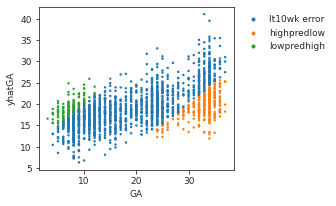

In [7]:
# plot again
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
sns.scatterplot(x='GA', y='yhatGA', hue='Error group', data=md, rasterized=True, 
                linewidth=0, ax=ax, s=6)
ax.legend(bbox_to_anchor=(1.01, 1))

if savefigs:
    fig.savefig('/home/ngr4/project/wearables/results/ITRerror_analysis_error_groups.png',
                bbox_inches='tight', dpi=600)
    savefigs = False

In [8]:
# statistical tests
def pd_chisq(df, feat, groupby='Error group'):
    from scipy.stats import chi2_contingency
    obs = md.groupby([groupby, feat]).size().unstack(fill_value=0)
    chi2, p, dof, expected = chi2_contingency(obs)
    return p, obs

def pd_kruskalwallis(df, feat, groupby='Error group'):
    size = []
    for i, g in enumerate(df[groupby].unique()):
        dt = df.loc[df[groupby]==g, feat].to_numpy()
        size.append(dt.shape[0])
        if i==0:
            X = dt
        else:
            X = np.concatenate((X, dt))
    X = np.split(X, np.cumsum(size[:-1]))
    from scipy.stats import kruskal
    statistic, p = kruskal(*X)
    return p

def pd_purity():
    '''Silhouette coefficient per var per cluster'''
    raise NotImplementedError

In [9]:
def stat_err_analysis(md, include_var_pred_performance=False, norm=True,
                      groupby='Error group', 
                      omit_cols=['index', 'record_id', 'pid', 'Absolute Error', 'yGA', 'yhatGA'],
                      out_file=None):
    res = pd.DataFrame()
    for i, col in enumerate([i for i in md.columns if i!=groupby and i not in omit_cols]):
        if md[col].dtype == object:
            p, obs = pd_chisq(md, col, groupby=groupby)
            dt = pd.DataFrame({'Variable': col, 'P': p, 
                               'Tasktype': 'Classification', 'Error group': None},
                              index=[0])
            dt.at[0, 'Error group'] = obs.to_dict()
        else:
            p = pd_kruskalwallis(md, col, groupby=groupby)
            dt = pd.DataFrame({'Variable': col, 'P': p, 
                               'Tasktype': 'Classification', 'Error group': None},
                              index=[0])
            dt.at[0, 'Error group'] = {'q{}'.format(i):md.groupby(groupby)[col].quantile(i).to_dict() for i in [0.25, 0.5, 0.75]}
        res = res.append(dt, ignore_index=True)
    if include_var_pred_performance:
        md_eval = allmd_results(norm=norm)
        res['eval_test'] = res['Variable'].map(md_eval)
    res['-log10(P)'] = -1*np.log10(res['P'])
    if out_file is not None:
        res.to_csv(out_file)
    return res

In [8]:
res = stat_err_analysis(md, include_var_pred_performance=True)

train set eval:
  bst epoch: None
  <loss_train>=63.5099
  eval_train  =6.7440


In [10]:
savefigs = True

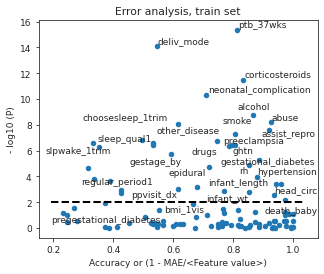

In [11]:
# plot and label
res = res.loc[res['-log10(P)'] < 100., :]

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(res['eval_test'], res['-log10(P)'], s=20, rasterized=True)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [2., 2.], 'k--', linewidth=2)
ax.set_xlabel('Accuracy or (1 - MAE/<Feature value>)')
ax.set_ylabel('- log10 (P)')

# label only significant ones
dt = res.loc[(res['-log10(P)'] >= 2.) & (res['eval_test']>0.5), :].reset_index()
texts = [ax.text(dt.loc[i, 'eval_test'], dt.loc[i, '-log10(P)'], dt.loc[i, 'Variable']) for i in range(dt.shape[0])]
from adjustText import adjust_text
adjust_text(texts)
ax.set_title('Error analysis, train set')

if savefigs:
    fig.savefig('/home/ngr4/project/wearables/results/ITRerror_analysis_PgroupdiffVmdpredperf.png',
                bbox_inches='tight', dpi=600)
    savefigs = False

#### next steps

Save results file but omit the normalization of the regression errors, as I think this confounds.


In [17]:
res = stat_err_analysis(md, include_var_pred_performance=True, norm=False,
                        out_file='/home/ngr4/project/wearables/results/IT_GA_stat_error_analysis.csv')

In [20]:
res.sort_values(by='P').head(10)

,Variable,P,Tasktype,Error group,eval_test,-log10(P)
0,GA,6.497872e-188,Classification,"{'q0.25': {'highpredlow': 32.0, 'lowpredhigh':...",9.129624,187.187229
42,ptb_37wks,4.725510e-16,Classification,"{'0.0': {'highpredlow': 308, 'lowpredhigh': 11...",0.812000,15.325551
59,deliv_mode,8.335504e-15,Classification,"{'1.0': {'highpredlow': 209, 'lowpredhigh': 87...",0.544000,14.079068
37,corticosteroids,3.226126e-12,Classification,"{'0.0': {'highpredlow': 305, 'lowpredhigh': 11...",0.832000,11.491319
64,neonatal_complication,5.111566e-11,Classification,"{'0.0': {'highpredlow': 256, 'lowpredhigh': 99...",0.708000,10.291446
11,alcohol,1.744642e-09,Classification,"{'0.0': {'highpredlow': 318, 'lowpredhigh': 12...",0.864000,8.758294
38,abuse,5.929172e-09,Classification,"{'1.0': {'highpredlow': 1, 'lowpredhigh': 3, '...",0.924000,8.227006
81,choosesleep_1trim,7.976030e-09,Classification,"{'-99.0': {'highpredlow': 11, 'lowpredhigh': 3...",0.616000,8.098213
39,assist_repro,2.507223e-08,Classification,"{'1.0': {'highpredlow': 5, 'lowpredhigh': 4, '...",0.920000,7.600807
12,smoke,5.487040e-08,Classification,"{'0.0': {'highpredlow': 299, 'lowpredhigh': 12...",0.804000,7.260662


### See how to split data by ptb_37


In [10]:
res = stat_err_analysis(md, include_var_pred_performance=True, norm=False)
res.sort_values(by='P').head(5)

,Variable,P,Tasktype,Error group,eval_test,-log10(P)
0,GA,6.497872e-188,Classification,"{'q0.25': {'highpredlow': 32.0, 'lowpredhigh':...",9.129624,187.187229
42,ptb_37wks,4.725510e-16,Classification,"{'0.0': {'highpredlow': 308, 'lowpredhigh': 11...",0.812000,15.325551
59,deliv_mode,8.335504e-15,Classification,"{'1.0': {'highpredlow': 209, 'lowpredhigh': 87...",0.544000,14.079068
37,corticosteroids,3.226126e-12,Classification,"{'0.0': {'highpredlow': 305, 'lowpredhigh': 11...",0.832000,11.491319
64,neonatal_complication,5.111566e-11,Classification,"{'0.0': {'highpredlow': 256, 'lowpredhigh': 99...",0.708000,10.291446


In [16]:
res.loc[res['Variable']=='ptb_37wks', 'Error group'].values[0]

{'0.0': {'highpredlow': 308, 'lowpredhigh': 111, 'lt10wk error': 1335},
 '1.0': {'highpredlow': 19, 'lowpredhigh': 19, 'lt10wk error': 210},
 '2.0': {'highpredlow': 0, 'lowpredhigh': 27, 'lt10wk error': 87}}

In [38]:
# compare expected vs observed in plot
def group_stat(md, col, include_var_pred_performance=False, norm=True,
                      groupby='Error group', 
                      omit_cols=['index', 'record_id', 'pid', 'Absolute Error', 'yGA', 'yhatGA'],
                      out_file=None):
    def pd_chisq(df, feat, groupby='Error group'):
        from scipy.stats import chi2_contingency
        obs = md.groupby([groupby, feat]).size().unstack(fill_value=0)
        chi2, p, dof, expected = chi2_contingency(obs)
        return p, obs, expected
    
    if md[col].dtype == object:
        p, obs, expected = pd_chisq(md, col, groupby=groupby)
        expected = pd.DataFrame(expected, 
                                index=obs.index.to_list(), 
                                columns=obs.columns.to_list())
        out = {'Variable': col, 'P': p, 
               'Tasktype': 'Classification', 
               'Observed': obs.to_dict(),
               'Expected': expected.to_dict()}
    else:
        p = pd_kruskalwallis(md, col, groupby=groupby)
        out = {'Variable': col, 'P': p,
               'Tasktype': 'Classification', 
               'Observed': {'q{}'.format(i):md.groupby(groupby)[col].quantile(i).to_dict() for i in [0.25, 0.5, 0.75]}}
    return out

In [83]:
obs = res['Observed']
exp = res['Expected']
key = {'0.0':'No', '1.0':'Yes', '2.0':'Unknown'}

In [88]:
['{}_{}'.format(group, k), '{}_{}'.format(group, k)]

['highpredlow_No', 'highpredlow_No']

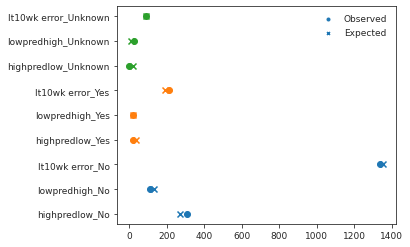

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
for i, (k,v) in enumerate(obs.items()):
    if key is not None:
        k = key[k]
    for j, group in enumerate(v.keys()):
#         ax.plot([0, v[group]], ['{}_{}'.format(group, k), '{}_{}'.format(group, k)], '--', color=sns.color_palette()[i])
        if i==0 and j==0:
            label = 'Observed'
        else:
            label = None
        ax.scatter(v[group], '{}_{}'.format(group, k), marker='o', color=sns.color_palette()[i], label=label)
for i, (k,v) in enumerate(exp.items()):
    if key is not None:
        k = key[k]
    for j, group in enumerate(v.keys()):
        if i ==0 and j==0:
            label = 'Expected'
        else:
            label = None
#         ax.plot([0, v[group]], ['{}_{}'.format(group, k), '{}_{}'.format(group, k)], '--', color=sns.color_palette()[i])
        ax.scatter(v[group], '{}_{}'.format(group, k), marker='x', color=sns.color_palette()[i], label=label)
ax.legend()

fig.savefig('/home/ngr4/project/wearables/results/group_stat_obsVexp_ptb37wks.png', bbox_inches='tight', dpi=300)

In [58]:
def plot(obs, exp, key={'0.0':'No', '1.0':'Yes', '2.0':'Unknown'}):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    for i, (k,v) in enumerate(obs.items()):
        if key is not None:
            k = key[k]
        for group in v.keys():
            ax.scatter([0, v[group]], ['{}_{}'.format(group, k), '{}_{}'.format(group, k)], '--', color=sns.color_palette()[i])
            ax.scatter([0, v[group]], ['{}_{}'.format(group, k), '{}_{}'.format(group, k)], 'o', color=sns.color_palette()[i], label='Observed')
    for i, (k,v) in enumerate(exp.items()):
        if key is not None:
            k = key[k]
        for group in v.keys():
            ax.scatter([0, v[group]], ['{}_{}'.format(group, k), '{}_{}'.format(group, k)], '--', color=sns.color_palette()[i])
            ax.scatter([0, v[group]], ['{}_{}'.format(group, k), '{}_{}'.format(group, k)], 'x', color=sns.color_palette()[i], label='Expected')
    ax.legend()
    

In [102]:
res = group_stat(md, 'ptb_37wks')
print('observed: ')
for k in res['Observed']:
    print('  ', res['Observed'][k])
print('')
print('expected: ')
for k in res['Expected']:
    print('  ', res['Expected'][k])

observed: 
   {'highpredlow': 308, 'lowpredhigh': 111, 'lt10wk error': 1335}
   {'highpredlow': 19, 'lowpredhigh': 19, 'lt10wk error': 210}
   {'highpredlow': 0, 'lowpredhigh': 27, 'lt10wk error': 87}

expected: 
   {'highpredlow': 271.0576559546314, 'lowpredhigh': 130.14083175803404, 'lt10wk error': 1352.8015122873346}
   {'highpredlow': 38.32514177693762, 'lowpredhigh': 18.400756143667298, 'lt10wk error': 191.27410207939508}
   {'highpredlow': 17.617202268431, 'lowpredhigh': 8.458412098298677, 'lt10wk error': 87.92438563327032}


ValueError: s must be a scalar, or float array-like with the same size as x and y

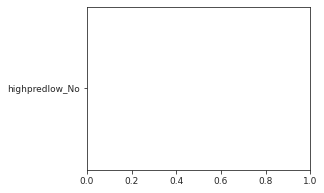

In [60]:
plot(res['Observed'], res['Expected'])

# Deprecated

In [2]:
# make other plots
import sys
sys.path.append('/home/ngr4/project/wearables/scripts')
import train as weartrain

trainer = weartrain.InceptionTimeRegressor_trainer(trial=0, 
                                                   patience=None, n_epochs=2000,
                                                   batch_size=32)

In [3]:
res = trainer.eval_test(modelpkl='/home/ngr4/project/wearables/model_zoo/61-InceptionTime_GA4.pkl', eval_trainset=True)

/gpfs/ysm/project/dijk/ngr4/conda_envs/wearables/lib/python3.8/site-packages/torch/nn/modules/conv.py:294: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/Convolution.cpp:660.)
  return F.conv1d(input, weight, bias, self.stride,
/gpfs/ysm/project/dijk/ngr4/conda_envs/wearables/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


train set eval:
  bst epoch: None
  <loss_train>=63.5099
  eval_train  =6.7440


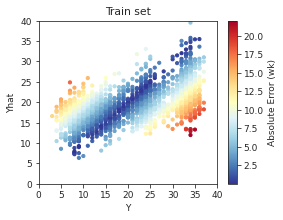

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

im = ax.scatter(res['y'], res['yhat'], c=(res['yhat']-res['y']).abs(), s=10, cmap='RdYlBu_r', rasterized=True)
cbar = fig.colorbar(im)
cbar.set_label('Absolute Error (wk)')
ax.set_title('Train set')
ax.set_xlabel('Y')
ax.set_ylabel('Yhat')
ax.set_xlim([0, 40])
ax.set_ylim([0, 40])
ax.set_xticks(ax.get_yticks())

fig.savefig('/home/ngr4/project/wearables/results/ITRerror_analysis_yhatVy_trainset.png', bbox_inches='tight', dpi=600)

In [38]:
savefigs = True

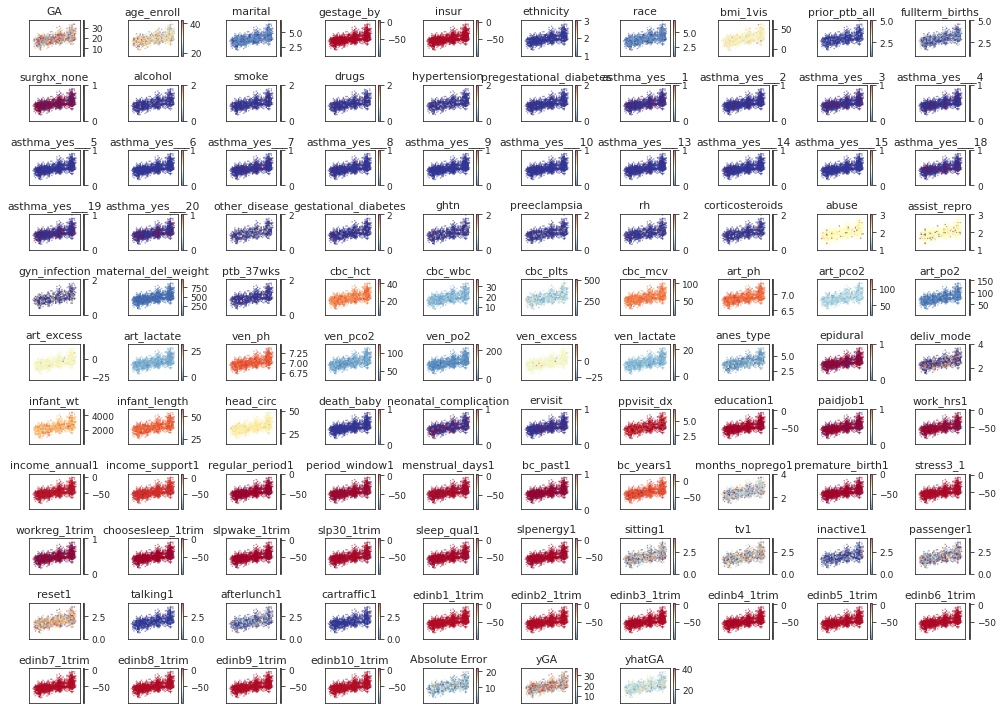

In [39]:
fig = plt.figure(figsize=(11 + 11*.25, 10))

for i, column in enumerate([j for j in res['md'].columns if j not in ['pid', 'record_id', 'index']]):
    ax = fig.add_subplot(11, 10, i+1)
    color = res['md'][column].astype(float) if isinstance(res['md'][column], object) else res['md'][column]
    im = ax.scatter(res['y'], res['yhat'], c=color, s=0.2, alpha=0.6, cmap='RdYlBu_r', rasterized=True)
    cbar = fig.colorbar(im)
    ax.set_title(column)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([0, 40])
    ax.set_ylim([0, 40])
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
if savefigs:
    fig.savefig('/home/ngr4/project/wearables/results/ITRerror_analysis_yhatVy_allmd.png', bbox_inches='tight', dpi=600)
    savefigs = False

# GAM

try to figure out what associates with the error



In [61]:
# data
error = (res['yhat']-res['y']).abs().numpy()
X = res['md'].loc[:, [j for j in res['md'].columns if j not in ['pid', 'record_id', 'index']]].to_numpy(dtype=float)

In [63]:
from pygam import LinearGAM

gam = LinearGAM()
gam.gridsearch(X, error)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:02:57 Time:  0:02:57


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    168.9063
Link Function:                     IdentityLink Log Likelihood:                                 -8097.6022
Number of Samples:                         2116 AIC:                                             16535.017
                                                AICc:                                           16564.8747
                                                GCV:                                               20.8208
                                                Scale:                                             17.8523
                                                Pseudo R-Squared:                                   0.0888
Feature Function                  Lam

/tmp/ipykernel_230443/4042498861.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [69]:
XX = gam.generate_X_grid(term=term_number)

In [70]:
XX.shape

(100, 107)

Text(0.5, 1.0, 'infant_length')

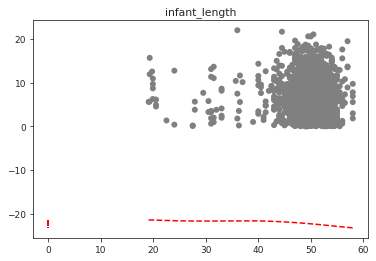

In [71]:
term_number = 61
term_names = [j for j in res['md'].columns if j not in ['pid', 'record_id', 'index']]

XX = gam.generate_X_grid(term=term_number, n=500)

plt.plot(XX, gam.predict(XX), 'r--')
# cis = gam.prediction_intervals(XX, width=.95)
# plt.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')

plt.scatter(X[:, term_number], error, facecolor='gray', edgecolors='none')
plt.title(term_names[term_number])

In [76]:
# GAM train error 
print('MAE GAM: {:.4f}-wks'.format(np.mean(np.abs(error - gam.predict(X)))))

MAE GAM: 3.3132-wks


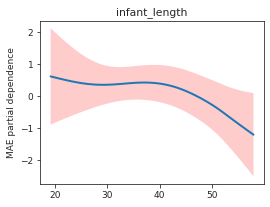

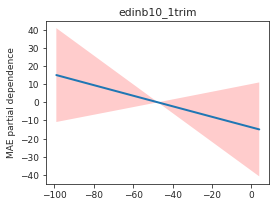

In [110]:
term_names = [j for j in res['md'].columns if j not in ['pid', 'record_id', 'index']]
for term_number in np.where(np.array(gam.statistics_['p_values']) < 0.01)[0]:
    XX = gam.generate_X_grid(term=term_number)
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(XX[:, term_number], gam.partial_dependence(term=int(term_number), X=XX), linewidth=2)
    cis = gam.partial_dependence(term=int(term_number), X=XX, width=.95)[1]
    ax.fill_between(XX[:, term_number], cis[:, 0], cis[:, 1], color='r', alpha=0.2, edgecolor='None')
    ax.set_title(term_names[term_number])
    if False:
        im = ax.scatter(X[:, term_number], error - np.mean(error), c=X[:, 0], cmap='RdYlBu_r', rasterized=True, s=0.25)
        cbar = fig.colorbar(im)
        cbar.set_label('GA')
    ax.set_ylabel('MAE partial dependence')
    fig.savefig('/home/ngr4/project/wearables/results/ITRerror_analysis_sigpartialdep_{}.png'.format(term_names[term_number]), bbox_inches='tight', dpi=600)

In [118]:
pvals = -1*np.log10(np.array(gam.statistics_['p_values']))

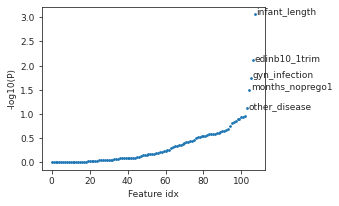

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.scatter(np.arange(len(pvals)), pvals[np.argsort(pvals)], s=3, )
for i in range(5):
    ax.text(np.arange(len(pvals))[-1 - i]+1, pvals[np.argsort(pvals)][-1 - i], term_names[np.argsort(pvals)[-1 -i]])
ax.set_ylabel('-log10(P)')
ax.set_xlabel('Feature idx')
fig.savefig('/home/ngr4/project/wearables/results/ITRerror_analysis_featimprank.png', bbox_inches='tight', dpi=600)

# chi square tests